In [1]:
import os 
os.chdir("/home/canyon/Bus-Weather-Impacts")
from src.utils import *
import pandas as pd
import os
import osmnx as ox
import numpy as np
import geopandas as gpd
import networkx as nx
from sklearn.neighbors import KDTree
import numpy as np
pd.options.mode.chained_assignment = None
pd.set_option('display.float_format', '{:.02f}'.format)
from geopy.distance import geodesic
from shapely.ops import linemerge
pd.set_option('display.float_format', lambda x: '%.6f' % x)
pd.set_option('display.max_columns', None)
import contextily as ctx
from src.api import parse_zipped_gtfs
import matplotlib.pyplot as plt
from src.gtfs_segments import GTFS_shape_processor
from shapely.geometry import Point
from plotnine import *
import statsmodels.api as sm
from statsmodels.formula.api import mixedlm

In [2]:
gtfs_speed = read_speeds_between_dates("2023-09-18", "2023-10-30").query("speed_mph < 70 & speed_mph > 0")

In [3]:
full_trips = pd.read_parquet("/home/data/bus-weather/nyc_trip_shapes.parquet")
gtfs_speed = full_trips.merge(gtfs_speed)

In [4]:
segments = gpd.read_parquet("/home/data/bus-weather/bus_segments_2023_09_18.parquet")

In [6]:
ntas_url = "https://data.cityofnewyork.us/api/geospatial/d3qk-pfyz?method=export&format=GeoJSON"
ntas = gpd.read_file(ntas_url).to_crs(2263)
seg_ntas = segments.overlay(ntas)
seg_ntas["seg_length"] = seg_ntas.length
seg_ntas = seg_ntas.sort_values(["shape_id", "stop_id", "prev_stop_id", "seg_length"]).drop_duplicates(["shape_id", "stop_id", "prev_stop_id"], keep = "first")
seg_ntas = seg_ntas[["shape_id", "stop_id", "prev_stop_id", "boroname", "ntaname", "ntacode"]]

In [7]:
segments = segments.merge(seg_ntas, how = "left")

In [8]:
gtfs_speed = gtfs_speed.merge(segments)

In [9]:
gtfs_speed["date"] = gtfs_speed.interpolated_time.dt.date.astype(str)
gtfs_speed["hour"] = gtfs_speed.interpolated_time.dt.hour.astype(int)
gtfs_speed["day_of_week"] = gtfs_speed["interpolated_time"].dt.dayofweek

In [10]:
nta_speed_and_volume_averages = gtfs_speed.groupby(["ntaname", "day_of_week", "hour"]).agg(average_speed = ("speed_mph", "mean"),
                                                                                           total_trips = ("unique_trip_id", "nunique")).reset_index()

In [11]:
nta_speed_and_volume_averages

,ntaname,day_of_week,hour,average_speed,total_trips
0,Airport,0,0,18.728426,163
1,Airport,0,1,20.040837,164
2,Airport,0,2,19.795106,200
3,Airport,0,3,19.329284,238
4,Airport,0,4,17.388468,388
...,...,...,...,...,...
32728,park-cemetery-etc-Staten Island,6,19,22.154368,44
32729,park-cemetery-etc-Staten Island,6,20,23.258194,48
32730,park-cemetery-etc-Staten Island,6,21,22.923278,41
32731,park-cemetery-etc-Staten Island,6,22,24.564222,34


In [41]:
UN_week_dates = ["2023-09-19","2023-09-20", "2023-09-21", "2023-09-22"]

In [42]:
gtfs_speed["unweek"] = gtfs_speed["date"].isin(UN_week_dates)

In [43]:
un_speeds = gtfs_speed.query("unweek").groupby(["ntaname", "boroname", "day_of_week", "hour"]).agg(average_speed_un = ("speed_mph", "mean"),
                                                                                           total_trips_un = ("unique_trip_id", "nunique")).reset_index()

In [44]:
un_comp = un_speeds.merge(nta_speed_and_volume_averages)
un_comp["diff"] = un_comp["average_speed_un"] - un_comp["average_speed"]
un_comp["diff_pct"] = un_comp["diff"] / un_comp["average_speed"]

In [45]:
un_comp.query("boroname == 'Brooklyn'  & hour > 10 & hour < 18").groupby("ntaname")["diff_pct"].mean().reset_index().sort_values("diff_pct")

,ntaname,diff_pct
48,Williamsburg,-0.087139
5,Borough Park,-0.053229
36,Ocean Parkway South,-0.044116
15,Crown Heights South,-0.029405
32,Madison,-0.020779
30,Homecrest,-0.019452
27,Georgetown-Marine Park-Bergen Beach-Mill Basin,-0.017659
45,Sunset Park East,-0.017453
4,Bensonhurst West,-0.013881
33,Midwood,-0.013702


In [46]:
plot_dat = un_comp.query("boroname == 'Manhattan' & hour > 7 & hour < 20").groupby("ntaname")["diff_pct"].mean().reset_index().sort_values("diff_pct")
plot_dat

,ntaname,diff_pct
11,Lenox Hill-Roosevelt Island,-0.100607
21,Turtle Bay-East Midtown,-0.074938
18,Murray Hill-Kips Bay,-0.059947
22,Upper East Side-Carnegie Hill,-0.046329
16,Midtown-Midtown South,-0.042452
12,Lincoln Square,-0.032746
24,Washington Heights North,-0.026427
14,Manhattanville,-0.010896
9,Hamilton Heights,-0.010152
2,Central Harlem South,-0.010007


<Axes: >

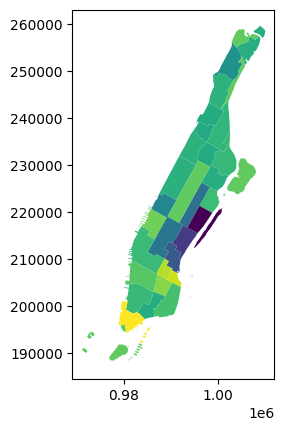

In [47]:
ntas.merge(plot_dat).plot("diff_pct")

In [35]:
gtfs_speed.query("boroname == 'Manhattan'").groupby("hour")["speed_mph"].median()

hour
0    10.883788
1    11.746949
2    11.990159
3    11.611652
4    10.082314
5     8.405001
6     6.774101
7     6.148574
8     6.143639
9     5.912999
10    5.701765
11    5.514754
12    5.498414
13    5.350749
14    5.255155
15    5.363084
16    5.455952
17    5.839777
18    6.341320
19    6.921795
20    7.415150
21    7.885890
22    8.498463
23    9.581304
Name: speed_mph, dtype: float64